In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from distfit import distfit
import re
from sympy import symbols, simplify, sin, cos, log, Abs, exp, expand_power_base, Mul, Rational, sqrt
from sympy.parsing.sympy_parser import parse_expr
import seaborn as sns
import copy
import json
from ydata_profiling import ProfileReport

In [2]:
df = pd.read_excel("C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/data/real_estate/real_estate_valuation.xlsx")
df = df.rename(columns={"X2 house age": "X1 house age", 
                        "X3 distance to the nearest MRT station": "X2 distance MRT station", 
                        "X4 number of convenience stores": "X3 number convenience stores", 
                        "X5 latitude": "X4 lat", 
                        "X6 longitude": "X5 long", 
                        "Y house price of unit area": "X6 price"})
df = df[["X1 house age", "X2 distance MRT station", "X3 number convenience stores", "X4 lat", "X5 long", "X6 price"]]

In [10]:
df.to_csv("C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/data/real_estate/real_estate_valuation_cleaned.csv", index=False)

In [3]:
# Generate the profiling report
profile = ProfileReport(df[["X1 house age", "X2 distance MRT station", "X3 number convenience stores", "X4 lat", "X5 long"]], title="Real Estate Valuation Cleaned - Excl X6 price", explorative=True)

# Display the report in the notebook
# profile.to_notebook_iframe()

# Alternatively, save the report to an HTML file
# profile.to_file('../../profiling/profiling_report_real_estate_valuation_cleaned_excl_price.html')

In [4]:
# Get the description object
desc = profile.get_description()

# Access the correlation matrix
correlation_matrix = desc.correlations["auto"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
expression_str_raw = "sqrt(x1) + (111.49027 - (log(x0 - -163.37123) * 11.177385))"
num_independent_vars = 2

def generate_var_string(num_independent_vars):
    var_string = ''
    for i in range(num_independent_vars):
        var_string = var_string + ('x' + str(i) + ' ')
    return var_string[0:len(var_string) - 1]

variables = generate_var_string(2)

exec(f"{', '.join(variables.split())} = symbols('{variables}')")

parsed_expr = parse_expr(expression_str_raw)
expr = simplify(parsed_expr)
print(expr)

sqrt(x1) - 11.177385*log(x0 + 163.37123) + 111.49027


In [4]:
# define variables to use in expression
x0_ = df['X2 distance MRT station'].to_numpy()
x1_ = df['X3 number convenience stores'].to_numpy()

price_predicted = np.sqrt(x1_) - 11.177385*np.log(x0_ + 163.37123) + 111.49027

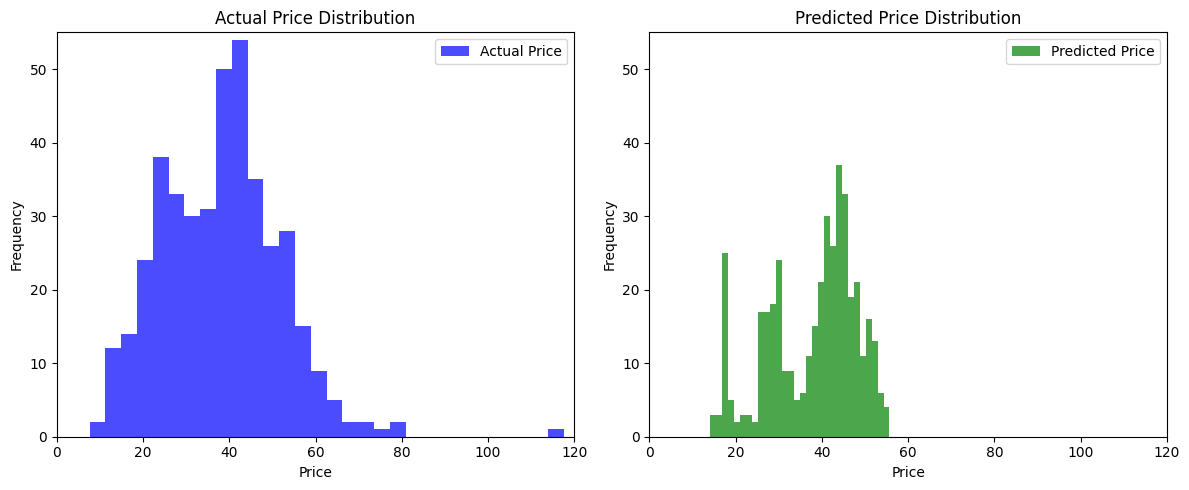

In [8]:
# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Plot the Actual Interest Rate distribution
plt.subplot(1, 2, 1)
plt.hist(df['X6 price'], bins=30, alpha=0.7, color='blue', label='Actual Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Actual Price Distribution')
plt.legend()
plt.xlim(0, 120)
plt.ylim(0, 55)

# Plot the Predicted Interest Rate distribution
plt.subplot(1, 2, 2)
plt.hist(price_predicted, bins=30, alpha=0.7, color='green', label='Predicted Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Predicted Price Distribution')
plt.legend()
plt.xlim(0, 120)
plt.ylim(0, 55)

plt.tight_layout()
plt.show()

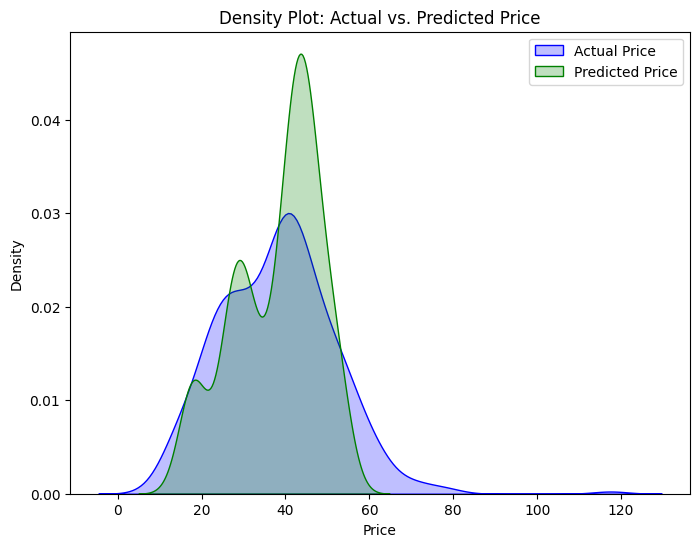

In [9]:
# density plots

plt.figure(figsize=(8, 6))
sns.kdeplot(df['X6 price'], fill=True, color='blue', label='Actual Price')
sns.kdeplot(price_predicted, fill=True, color='green', label='Predicted Price')
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Density Plot: Actual vs. Predicted Price')
plt.legend()
plt.show()

In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assume these are your pandas Series and DataFrame:
# interest_rate_predicted: SR prediction (Series)
# residuals: computed residuals = actual - SR prediction (Series)
# df: DataFrame that includes the original features and the 'Interest_Rate' column

# For this example, select some original features:
features_df = df[['X2 distance MRT station', 'X3 number convenience stores']]
residuals = df['X6 price'] - price_predicted
residuals = residuals.reset_index(drop=True)
price_predicted = pd.Series(price_predicted)

# Combine SR prediction as an additional feature
X = pd.concat([features_df, price_predicted.rename("SR_pred")], axis=1)
y = residuals  # target: residuals computed from (actual - SR prediction)

# Split data for training and testing (if desired)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create XGBoost DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up parameters for regression
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 6
}

num_rounds = 5000
model_xgb = xgb.train(params, dtrain, num_rounds)

# Evaluate on test set
y_pred_test = model_xgb.predict(dtest)
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"XGBoost Residual Correction Test MSE: {mse_test:.4f}")

# For final predictions, use the full dataset:
dall = xgb.DMatrix(X)
predicted_residual_correction = model_xgb.predict(dall)

# Compute final prediction as the sum of the SR prediction and the predicted residual correction
final_prediction = price_predicted + predicted_residual_correction

# Optionally, compute overall MSE against actual values
final_mse = mean_squared_error(df['X6 price'], final_prediction)
print(f"Final MSE after XGBoost residual correction: {final_mse:.4f}")

XGBoost Residual Correction Test MSE: 53.4094
Final MSE after XGBoost residual correction: 16.3442


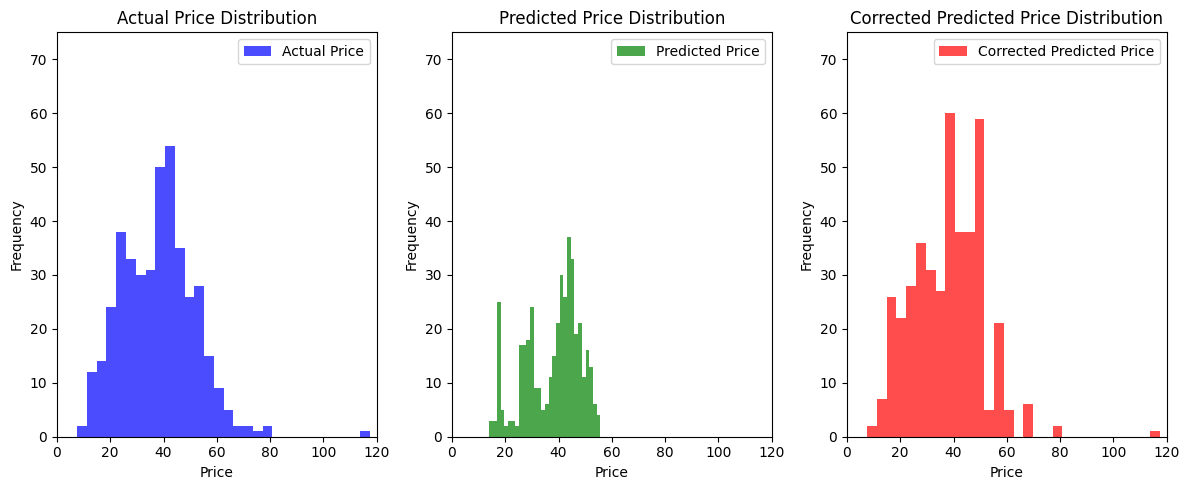

In [14]:
# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Plot the Actual Interest Rate distribution
plt.subplot(1, 3, 1)
plt.hist(df['X6 price'], bins=30, alpha=0.7, color='blue', label='Actual Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Actual Price Distribution')
plt.legend()
plt.xlim(0, 120)
plt.ylim(0, 75)

# Plot the Predicted Interest Rate distribution
plt.subplot(1, 3, 2)
plt.hist(price_predicted, bins=30, alpha=0.7, color='green', label='Predicted Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Predicted Price Distribution')
plt.legend()
plt.xlim(0, 120)
plt.ylim(0, 75)

# Plot the Predicted Interest Rate distribution
plt.subplot(1, 3, 3)
plt.hist(final_prediction, bins=30, alpha=0.7, color='red', label='Corrected Predicted Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Corrected Predicted Price Distribution')
plt.legend()
plt.xlim(0, 120)
plt.ylim(0, 75)

plt.tight_layout()
plt.show()

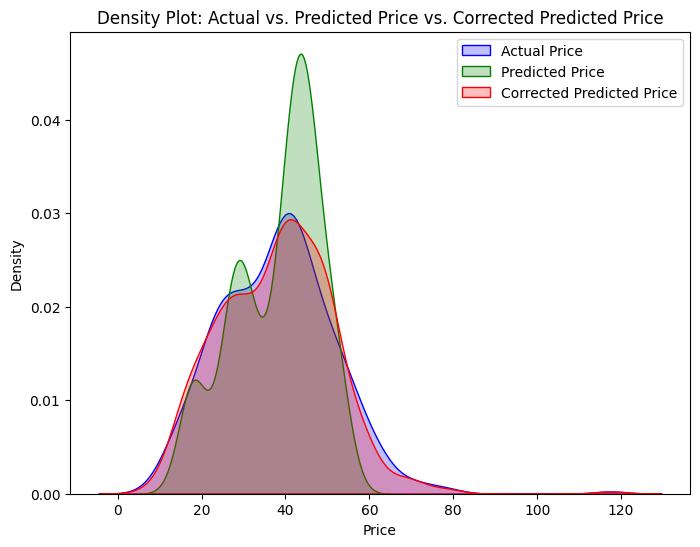

In [15]:
# density plots

plt.figure(figsize=(8, 6))
sns.kdeplot(df['X6 price'], fill=True, color='blue', label='Actual Price')
sns.kdeplot(price_predicted, fill=True, color='green', label='Predicted Price')
sns.kdeplot(final_prediction, fill=True, color='red', label='Corrected Predicted Price')
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Density Plot: Actual vs. Predicted Price vs. Corrected Predicted Price')
plt.legend()
plt.show()

In [17]:
# Dictionary to store results for each numeric column
fitted_results = {}

# Get a list of numeric columns in your DataFrame
numeric_cols = df.select_dtypes(include='number').columns

# remove target var from symbolic regression
numeric_cols = numeric_cols.drop('X6 price')

# Define the subset of distributions to test.
# (You can change this list as needed.)
desired_dists = ['norm', 'lognorm', 'gamma']

for col in numeric_cols:
    print(f"Processing column: {col}")
    
    # Extract and clean the data for the current column
    data = df[col].dropna().values
    
    # Initialize a distfit object, restricting to only the desired distributions.
    # Setting verbose=0 will suppress the printed log.
    dfit = distfit(distr=desired_dists, verbose=0)
    
    # Fit the distributions on the data.
    dfit.fit_transform(data)
    
    # Retrieve the summary DataFrame that contains the fit results.
    summary_df = dfit.summary
    
    if not summary_df.empty:
        # Choose the best fit as the one with the lowest RSS (score)
        best_dist = summary_df['score'].idxmin()
        best_params = summary_df.loc[best_dist].to_dict()
        
        # Store the result for this column
        fitted_results[col] = {
            'best_distribution': best_dist,
            'parameters': best_params
        }
    else:
        fitted_results[col] = None

# Print the summarized fitted distributions per numeric column
# print("\nFitted distributions per numeric column:")
# for col, result in fitted_results.items():
#     print(f"\nColumn: {col}")
#     if result is not None:
#         # print("  Best Distribution:", result['best_distribution'])
#         print("  Parameters:")
#         for param, value in result['parameters'].items():
#             print(f"    {param}: {value}")
#     else:
#         print("  No fit available.")

Processing column: X1 house age
Processing column: X2 distance MRT station
Processing column: X3 number convenience stores
Processing column: X4 lat
Processing column: X5 long


In [6]:
print(correlation_matrix)

corr_statements = []
corr_permutations = []

for column in correlation_matrix:
    for i in range(len(correlation_matrix)):
        current = correlation_matrix[column][i]
        if current != 1 and np.abs(current) >= 0.2:
            first_arg = column.split(' ')[0]
            second_arg = (list(correlation_matrix.columns)[i]).split(' ')[0]
            r = current.round(2)
            corr_permutations.append([second_arg, first_arg, r])
            if [first_arg, second_arg, r] not in corr_permutations:
                corr_statements.append(f"Columns {first_arg} and {second_arg} (r = {r})")

for corr_statement in corr_statements:
    print(corr_statement)

                              X1 house age  X2 distance MRT station  \
X1 house age                      1.000000                 0.129605   
X2 distance MRT station           0.129605                 1.000000   
X3 number convenience stores      0.009240                -0.688165   
X4 lat                            0.042142                -0.425107   
X5 long                          -0.109674                -0.469393   

                              X3 number convenience stores    X4 lat   X5 long  
X1 house age                                      0.009240  0.042142 -0.109674  
X2 distance MRT station                          -0.688165 -0.425107 -0.469393  
X3 number convenience stores                      1.000000  0.429476  0.412054  
X4 lat                                            0.429476  1.000000  0.264922  
X5 long                                           0.412054  0.264922  1.000000  
Columns X2 and X3 (r = -0.69)
Columns X2 and X4 (r = -0.43)
Columns X2 and X5 (r = -0.4

In [41]:
import bnlearn as bn


# 2) Discretize numerical columns into 5 bins (quantiles)
df_discrete = df.copy()
df_discrete = df_discrete.drop(['X6 price'], axis=1)
df_discrete['X1 house age'] = pd.qcut(df_discrete['X1 house age'], q=5, labels=False)
df_discrete['X2 distance MRT station'] = pd.qcut(df_discrete['X2 distance MRT station'], q=5, labels=False)
df_discrete['X4 lat'] = pd.qcut(df_discrete['X4 lat'], q=5, labels=False)
df_discrete['X5 long'] = pd.qcut(df_discrete['X5 long'], q=5, labels=False)

# (X3 number convenience stores is already integer but might still be binned 
#  or turned into categories if needed. Here we leave it as-is.)

# 3) Fit the Bayesian network using bnlearn
model = bn.structure_learning.fit(df_discrete, methodtype='hc', scoretype='bic')

# 4) Check out the resulting edges
print(model['model_edges'])

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[('X2 distance MRT station', 'X1 house age'), ('X3 number convenience stores', 'X5 long'), ('X5 long', 'X2 distance MRT station'), ('X5 long', 'X4 lat')]


In [46]:
chatgpt_bayesian_table = pd.read_excel("C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/data/real_estate/generated_bayesian_table_chatgpt.xlsx")
chatgpt_table = pd.read_excel("C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/data/real_estate/generated_table_chatgpt.xlsx")

In [45]:
# Generate the profiling report
profile = ProfileReport(chatgpt_table, title="Real Estate Valuation - ChatGPT Bayesian Table", explorative=True)

# Display the report in the notebook
# profile.to_notebook_iframe()

# Alternatively, save the report to an HTML file
profile.to_file('../../profiling/profiling_report_real_estate_chatgpt_bayesian_table.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# define variables to use in expression
x0_ = chatgpt_table['X2'].to_numpy()
x1_ = chatgpt_table['X3'].to_numpy()

price_predicted_gpt = np.sqrt(x1_) - 11.177385*np.log(x0_ + 163.37123) + 111.49027

final_prediction_gpt = price_predicted_gpt + predicted_residual_correction

full_chatgpt_table = chatgpt_table.copy()

full_chatgpt_table['X6'] = final_prediction_gpt

,X1,X2,X3,X4,X5,X6
0,30.141040,187.627020,5,24.986951,121.542651,41.712919
1,2.929310,1670.142749,3,24.958777,121.534250,25.715934
2,16.985685,405.247588,4,24.970952,121.514720,49.985225
3,19.742675,2280.226797,0,24.971974,121.525803,31.688413
4,14.747365,3364.981944,0,24.956329,121.525263,21.390492
...,...,...,...,...,...,...
409,19.222006,2359.625982,3,24.956242,121.513719,23.599168
410,19.341262,1111.468135,0,24.980725,121.515620,36.293700
411,23.329124,2449.736187,1,24.946232,121.526673,21.617005
412,9.997594,418.177965,2,24.979331,121.535118,39.783733


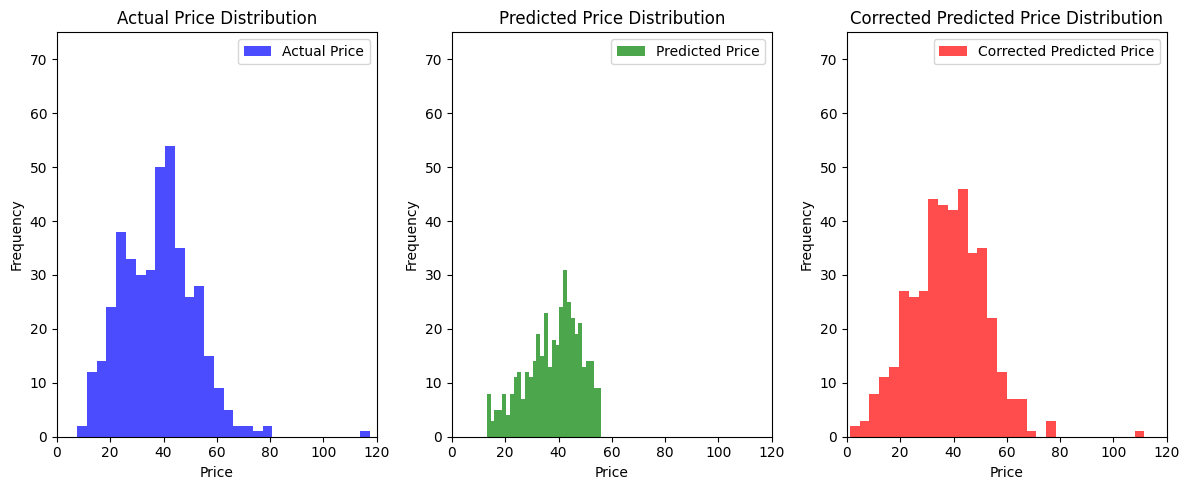

In [49]:
# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Plot the Actual Interest Rate distribution
plt.subplot(1, 3, 1)
plt.hist(df['X6 price'], bins=30, alpha=0.7, color='blue', label='Actual Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Actual Price Distribution')
plt.legend()
plt.xlim(0, 120)
plt.ylim(0, 75)

# Plot the Predicted Interest Rate distribution
plt.subplot(1, 3, 2)
plt.hist(price_predicted_gpt, bins=30, alpha=0.7, color='green', label='Predicted Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Predicted Price Distribution')
plt.legend()
plt.xlim(0, 120)
plt.ylim(0, 75)

# Plot the Predicted Interest Rate distribution
plt.subplot(1, 3, 3)
plt.hist(final_prediction_gpt, bins=30, alpha=0.7, color='red', label='Corrected Predicted Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Corrected Predicted Price Distribution')
plt.legend()
plt.xlim(0, 120)
plt.ylim(0, 75)

plt.tight_layout()
plt.show()

In [55]:
# define variables to use in expression
x0_ = chatgpt_bayesian_table['X2'].to_numpy()
x1_ = chatgpt_bayesian_table['X3'].to_numpy()

price_predicted_gpt_bayesian = np.sqrt(x1_) - 11.177385*np.log(x0_ + 163.37123) + 111.49027

final_prediction_gpt_bayesian = price_predicted_gpt_bayesian + predicted_residual_correction

full_chatgpt_bayesian_table = chatgpt_bayesian_table.copy()

full_chatgpt_bayesian_table['X6'] = final_prediction_gpt_bayesian

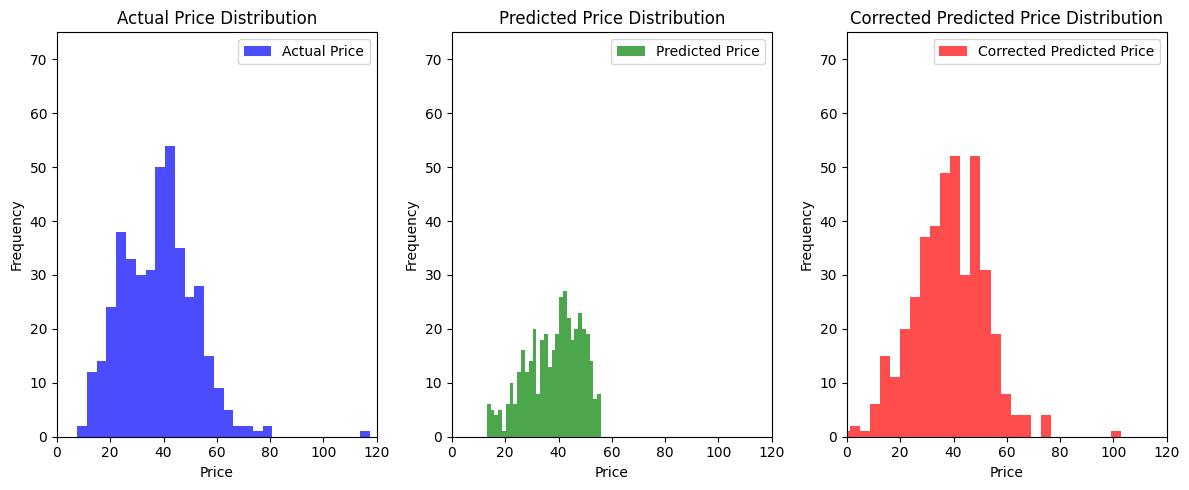

In [51]:
# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Plot the Actual Interest Rate distribution
plt.subplot(1, 3, 1)
plt.hist(df['X6 price'], bins=30, alpha=0.7, color='blue', label='Actual Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Actual Price Distribution')
plt.legend()
plt.xlim(0, 120)
plt.ylim(0, 75)

# Plot the Predicted Interest Rate distribution
plt.subplot(1, 3, 2)
plt.hist(price_predicted_gpt_bayesian, bins=30, alpha=0.7, color='green', label='Predicted Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Predicted Price Distribution')
plt.legend()
plt.xlim(0, 120)
plt.ylim(0, 75)

# Plot the Predicted Interest Rate distribution
plt.subplot(1, 3, 3)
plt.hist(final_prediction_gpt_bayesian, bins=30, alpha=0.7, color='red', label='Corrected Predicted Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Corrected Predicted Price Distribution')
plt.legend()
plt.xlim(0, 120)
plt.ylim(0, 75)

plt.tight_layout()
plt.show()

In [61]:
from sdmetrics.reports.single_table import QualityReport

# Assuming your datasets are in pandas DataFrames:
# real_data and synthetic_data

df_anon = df.copy()

df_anon = df_anon.rename(columns={
                        "X1 house age" : "X1", 
                        "X2 distance MRT station" : "X2", 
                        "X3 number convenience stores" : "X3", 
                        "X4 lat" : "X4", 
                        "X5 long" : "X5", 
                        "X6 price" : "X6"})

# Create a minimal metadata dictionary manually
metadata = {
    "columns": {
        "X1": {"sdtype": "numerical"},
        "X2": {"sdtype": "numerical"},
        "X3": {"sdtype": "numerical"},
        "X4": {"sdtype": "numerical"},
        "X5": {"sdtype": "numerical"},
        "X6": {"sdtype": "numerical"}
    }
}

In [70]:
report_gpt = QualityReport()
report_gpt.generate(df_anon, full_chatgpt_table, metadata)

# Get overall quality score and detailed breakdown
report_gpt.get_details(property_name='Column Shapes')
# report_gpt.get_properties()
# fig_gpt = report_gpt.get_visualization(property_name='Column Pair Trends')
# fig_gpt.show()

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 6/6 [00:00<00:00, 999.52it/s]|
Column Shapes Score: 87.96%

(2/2) Evaluating Column Pair Trends: |██████████| 15/15 [00:00<00:00, 156.54it/s]|
Column Pair Trends Score: 94.29%

Overall Score (Average): 91.12%



,Column,Metric,Score
0,X1,KSComplement,0.785024
1,X2,KSComplement,0.927536
2,X3,KSComplement,0.920290
3,X4,KSComplement,0.910628
4,X5,KSComplement,0.772947
5,X6,KSComplement,0.961353


In [73]:
report_gpt_bayesian = QualityReport()
report_gpt_bayesian.generate(df_anon, full_chatgpt_bayesian_table, metadata)

# Get overall quality score and detailed breakdown
report_gpt.get_details(property_name='Column Pair Trends')

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 6/6 [00:00<00:00, 1318.76it/s]|
Column Shapes Score: 86.67%

(2/2) Evaluating Column Pair Trends: |██████████| 15/15 [00:00<00:00, 202.50it/s]|
Column Pair Trends Score: 95.79%

Overall Score (Average): 91.23%



,Column 1,Column 2,Metric,Score,Real Correlation,Synthetic Correlation
0,X1,X2,CorrelationSimilarity,0.943091,0.025622,-0.088196
1,X1,X3,CorrelationSimilarity,0.997103,0.049593,0.055386
2,X1,X4,CorrelationSimilarity,0.954619,0.054420,0.145182
3,X1,X5,CorrelationSimilarity,0.943920,-0.048520,0.063640
4,X1,X6,CorrelationSimilarity,0.855678,-0.210567,0.078077
5,X2,X3,CorrelationSimilarity,0.985145,-0.602519,-0.572810
6,X2,X4,CorrelationSimilarity,0.889720,-0.591067,-0.370506
7,X2,X5,CorrelationSimilarity,0.800937,-0.806317,-0.408191
8,X2,X6,CorrelationSimilarity,0.988973,-0.673613,-0.695667
9,X3,X4,CorrelationSimilarity,0.999825,0.444143,0.444494
